<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/Zman42/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exporting Libraries

In [1]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.5 MB/s eta 0:00:00


## Load and Stretch the RGB FITS Image

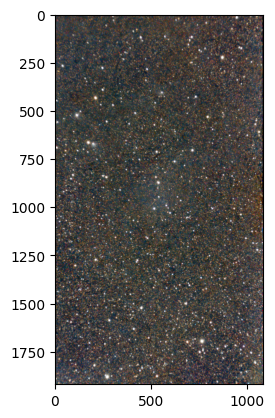

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/9.fits"

# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

## Count Stars Using Astropy

In [7]:
# Calculate the mean of the RGB channels
avg_channel = np.mean(rgb_data[:, :, :], axis=2)

def detect_stars(channel_data):
    """
    Detects stars in a 2D image using the DAOStarFinder algorithm.

    This function estimates the background statistics of the image using
    sigma-clipped statistics, then identifies star-like sources based on
    a Full Width at Half Maximum (FWHM) and a signal threshold.

    Parameters
    ----------
    channel_data : array_like
        A 2D NumPy array representing a single image channel (e.g., from a FITS image)
        where stars are to be detected. Pixel intensities should be linear (not log-scaled)
        and background-subtracted if possible.

    Returns
    -------
    astropy.table.Table
        A table of detected star sources, each with properties such as centroid
        positions, flux, sharpness, and roundness. Returns an empty table if no
        stars are found.

    Notes
    -----
    - Uses sigma-clipped statistics to robustly estimate the background mean,
      median, and standard deviation, excluding outliers like bright stars.
    - The DAOStarFinder algorithm identifies point sources based on their
      shape and brightness.
    - The detection threshold is set to 15 times the estimated background
      standard deviation, and the assumed FWHM of stars is 3 pixels.

    Examples
    --------
    >>> from astropy.io import fits
    >>> from astropy.stats import sigma_clipped_stats
    >>> from photutils.detection import DAOStarFinder
    >>> image_data = fits.getdata('example_image.fits')
    >>> stars = detect_stars(image_data)
    >>> print(len(stars))  # Number of stars detected
    """
    mean, median, std = sigma_clipped_stats(channel_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=3.0, threshold=15.0*std)
    return finder(channel_data - median)

def equalize_channels(rgb_data):
  '''
  This function takes in the RGB channel data and counts the "stars" in each channel.
  It makes sure the number of stars are the same for each by finding which channel has the least stars and
  making the other channels only contain that same number of stars.
  The stars removed start with the least bright, leaving only the brightest stars.
  '''
  # Exctract RGB channels seperately
  r_channel = rgb_data[:, :, 0]
  g_channel = rgb_data[:, :, 1]
  b_channel = rgb_data[:, :, 2]

  # Count the stars in each color channel
  r_sources = detect_stars(r_channel)
  g_sources = detect_stars(g_channel)
  b_sources = detect_stars(b_channel)

  # Sort stars by brightness
  r_sources.sort('peak')
  g_sources.sort('peak')
  b_sources.sort('peak')

  # Find the channel with the least number of bright stars
  min_stars = min(len(r_sources), len(g_sources), len(b_sources))

  # Keep only the brightest stars in each channel
  r_sources = r_sources[:min_stars]
  g_sources = g_sources[:min_stars]
  b_sources = b_sources[:min_stars]

  return r_sources, g_sources, b_sources, min_stars


# Detect stars
mean_sources = detect_stars(avg_channel)
mean_sources.sort('peak')
r_sources, g_sources, b_sources, min_stars = equalize_channels(rgb_data)
mean_sources_brightest = mean_sources[:min_stars]

# Print Results
print(f"Number of detected stars: {len(mean_sources)}") # Number of stars from average of color channels
print(f"Number of detected stars within brightness of RGB stars: {len(mean_sources_brightest)}") # Number of stars in brightness range
print(f"Number of detected red stars: {len(r_sources)}")
print(f"Number of detected green stars: {len(g_sources)}")
print(f"Number of detected blue stars: {len(b_sources)}") # Star number in each channel should be equal for fair comparison

Number of detected stars: 929
Number of detected stars within brightness of RGB stars: 590
Number of detected red stars: 590
Number of detected green stars: 590
Number of detected blue stars: 590


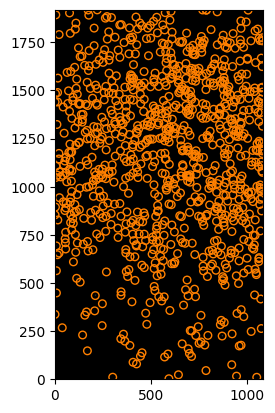

In [5]:
# Plot detected stars
plt.imshow(avg_channel, cmap='gray', origin='lower')
plt.scatter(mean_sources['xcentroid'], mean_sources['ycentroid'], s=30, edgecolor='#ff8000', facecolors='none')
plt.show()

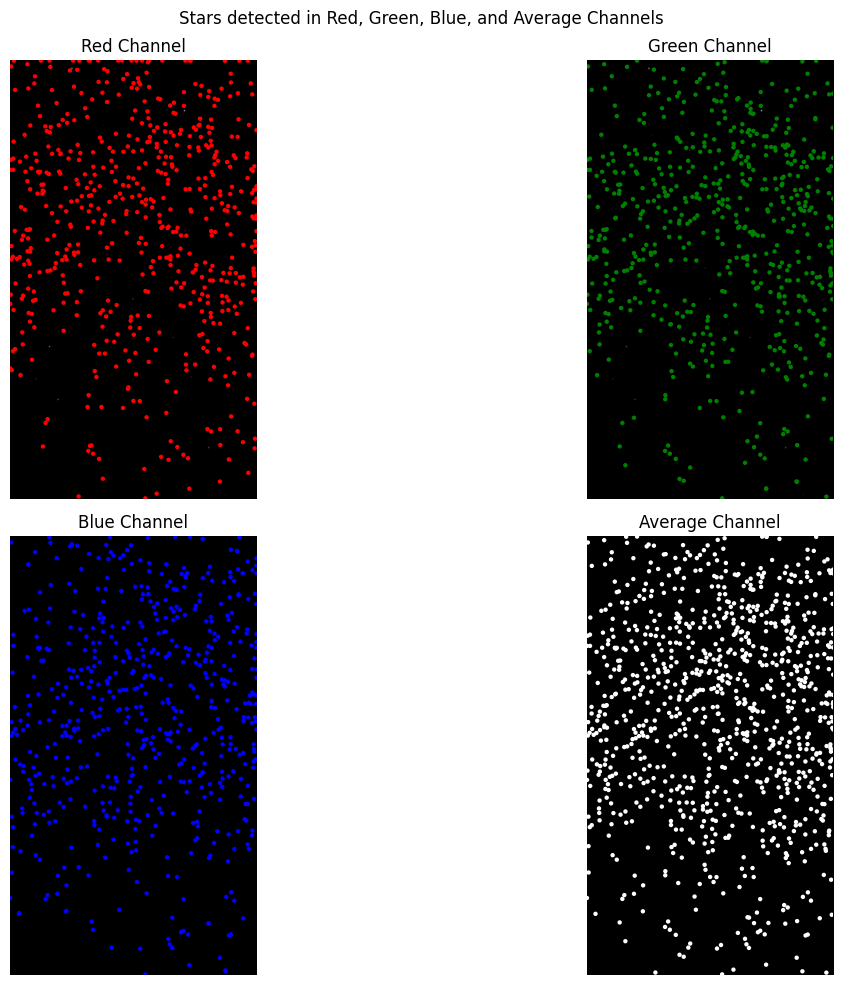

In [11]:
# 4-Sectioned plot:

# Channel data
r_channel = rgb_data[:, :, 0]
g_channel = rgb_data[:, :, 1]
b_channel = rgb_data[:, :, 2]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stars detected in Red, Green, Blue, and Average Channels')
titles = ['Red Channel', 'Green Channel', 'Blue Channel', 'Average Channel']
channels = [r_channel, g_channel, b_channel, avg_channel]
sources = [r_sources, g_sources, b_sources, mean_sources]
colors = ['r', 'g', 'b', 'w']

# Plot the stars for each channel
from photutils.aperture import CircularAperture
for ax, channel, sources, title, color in zip(axes.ravel(), channels, sources, titles, colors):
  ax.imshow(channel, cmap='gray', origin='lower')
  positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
  apertures = CircularAperture(positions, r=5.0)
  apertures.plot(ax, color=color, lw=1.5)
  ax.set_title(title)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Extract features (brightness and size)
flux = mean_sources_brightest['flux']

# Compute size proxy
size = mean_sources_brightest['sharpness']

# Color ratios
rg_ratio = r_sources['flux'] / g_sources['flux']
bg_ratio = b_sources['flux'] / g_sources['flux']

# Normalize features
flux_norm = (flux - np.min(flux)) / (np.max(flux) - np.min(flux))
size_norm = (size - np.min(size)) / (np.max(size) - np.min(size))
rg_norm = (rg_ratio - np.min(rg_ratio)) / (np.max(rg_ratio) - np.min(rg_ratio))
bg_norm = (bg_ratio - np.min(bg_ratio)) / (np.max(bg_ratio) - np.min(bg_ratio))

features = np.vstack([flux_norm, size_norm, rg_norm, bg_norm]).T

## Autoencoder for Feature Compression

In [39]:
# Define an autoencoder model
input_layer = Input(shape=(4,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(decoded)
decoded = Dense(4, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0867
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 16/50
37/37 

## Clustering with KMeans

In [40]:
# Clustering with kmeans
encoder = Model(input_layer, encoded)
encoded_features = encoder.predict(features)

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(encoded_features)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


## Visualizing Real Data

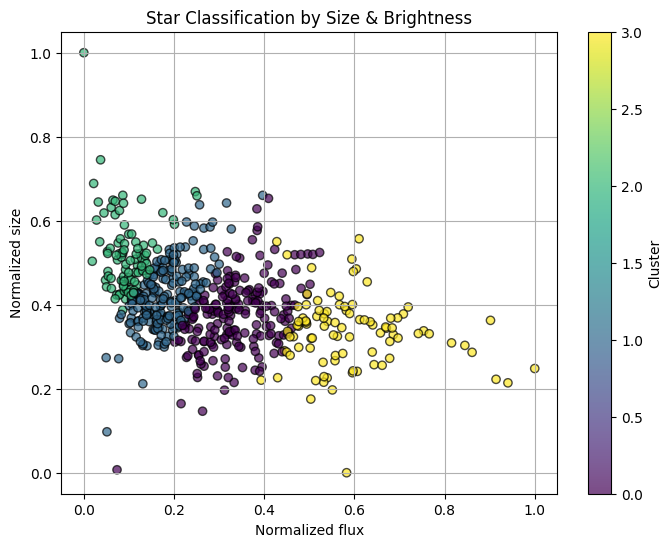

In [42]:
# Plotting flux and size
plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized flux')
plt.ylabel('Normalized size')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Size & Brightness')
plt.grid(True)
plt.show()

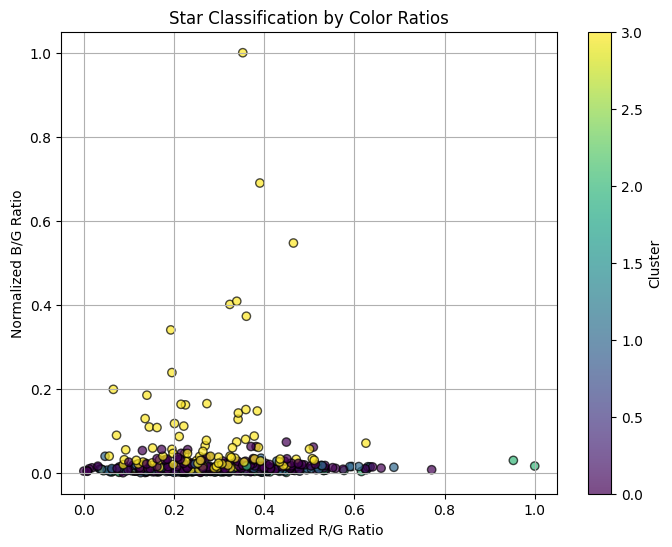

In [41]:
# Plotting color ratios
plt.figure(figsize=(8,6))
plt.scatter(rg_norm, bg_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Classification by Color Ratios')
plt.grid(True)
plt.show()